# CVRP Notebook
This notebook is intended to run the top level code for the CVRP

In [6]:
import networkx as nx


from model import VRP, create_constraints, output_variables
from pricer import VRPPricer
from parse import parse

from matplotlib import pyplot as plt

In [7]:
# Test instance E-n22-k4 provided by parser
# G = parse("Instances/E/E-n22-k4.vrp")
# G = parse("Instances/E/E-n23-k3.vrp")
# G = parse("Instances/E/E-n30-k3.vrp")
# G = parse("Instances/E/E-n33-k4.vrp")
# G = parse("Instances/E/E-n51-k5.vrp")
G = parse("Instances/E/E-n76-k14.vrp")

PARSE: Minimum number of trucks is 14


In [8]:
model = VRP(G)


# Create pricer
pricer = VRPPricer()
pricer.init_data(G)
pricer.data['elementary'] = True
pricer.data['max_vars']= 10000
pricer.data['abort_early'] = False
pricer.data['cyc2'] = False
pricer.data['ngParam'] = 8
pricer.data['ngPath'] = True
print(f"set teh parameter")

model.includePricer(pricer, "pricer","does pricing")

create_constraints(model,G)

# model.hideOutput()
model.optimize()
model.hideOutput(quiet=False)
# model.printBestSol()

set teh parameter
PRICER_PY: The maximal path length is 52
ngParam is 8
PRICER_C: Graph data successfully copied to C.
presolving:
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 75 variables (0 bin, 0 int, 0 impl, 75 cont) and 76 constraints
     76 constraints of type <linear>
Presolving Time: 0.00

PY PRICING: Found 893 paths with reduced cost
 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.2s|     1 |     0 |    25 |     - |  4157k |   0 | 968 |  76 |  76 |   0 |  0 |   0 |   0 |      --      |      --      |    Inf | unknown
PY PRICING: Found 509 paths with reduced cost
PY PRICING: Found 1097 paths with reduced cost
PY PRICING: Found 800 paths with reduced cost
PY PRICING: Found 3380 paths with 

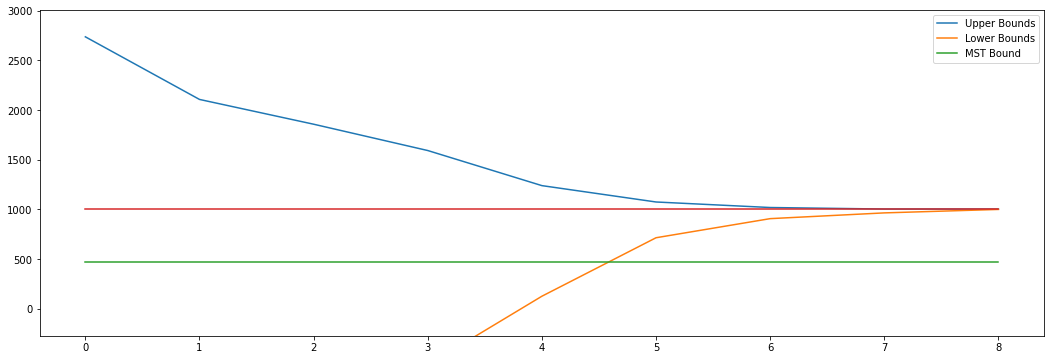

In [9]:
plt.figure(figsize=(18,6))
upper_bounds = [x for x,y in pricer.data['bounds']]
lower_bounds = [y for x,y in pricer.data['bounds']]
plt.plot(upper_bounds)
plt.plot(lower_bounds)
plt.ylim((-upper_bounds[0]/10,upper_bounds[0]*1.1))

T = nx.minimum_spanning_tree(G)
mst = T.size(weight='weight') + min(G.edges().data('weight'),key=lambda edge: edge[2])[2]
mst = [mst for i in range(len(upper_bounds))]
plt.plot(mst)

solval = model.getObjVal()
sol = [solval for i in range(len(upper_bounds))]
plt.plot(sol)

plt.legend(("Upper Bounds","Lower Bounds","MST Bound"))

plt.show()

In [10]:
output_variables(model, pricer)

The solution contains the following paths: 
Only paths with associated value larger than 1e-06 are analysed.
0.4806053085886923 * x104759: (0, 45, 29, 5, 48, 30, 0)
0.4612106171773849 * x110683: (0, 75, 4, 34, 46, 0)
0.06881204143288719 * x111149: (0, 67, 34, 4, 75, 0)
0.1013972809667675 * x112318: (0, 39, 25, 55, 18, 50, 44, 3, 0)
0.4770446698316789 * x114468: (0, 17, 40, 12, 26, 0)
0.39239857574449766 * x114823: (0, 67, 34, 52, 46, 0)
0.07757876564523025 * x116365: (0, 75, 34, 46, 67, 0)
0.06508955545964572 * x117759: (0, 21, 69, 71, 60, 70, 20, 37, 0)
0.36237591713422546 * x117824: (0, 7, 53, 14, 19, 8, 0)
0.17501078981441498 * x117876: (0, 72, 31, 25, 55, 18, 50, 44, 0)
0.07703927492447163 * x118168: (0, 27, 57, 20, 70, 60, 71, 69, 36, 0)
0.5 * x118650: (0, 22, 64, 42, 41, 56, 23, 0)
0.01939469141130773 * x118876: (0, 22, 64, 42, 43, 1, 63, 0)
0.049956840742338554 * x118970: (0, 47, 69, 71, 60, 70, 20, 15, 57, 0)
0.161793267155805 * x119015: (0, 65, 66, 11, 7, 0)
0.0875053949072075